# Spark Streaming et fenêtres

Use case : Flight tracking with OpenSky

### Imports

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType, TimestampType, FloatType, BooleanType


from pyspark.sql.functions import col, desc, sum, mean, min, max, lit, coalesce, bucket, col, window, avg ,count,from_json, when, current_timestamp
from matplotlib.pylab import mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [ ]:
conf = SparkConf() \
    .setAppName("SparkApp") \
    .setMaster("spark://spark:7077") \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")

# Build the SparkSession using the unified configuration
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Get the SparkContext from the SparkSession (if needed)
sc = spark.sparkContext

# Create a SQLContext (if needed for legacy operations)
sql_context = SQLContext(sc)

print("SparkSession and SparkContext successfully created.")

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-209612c0-a6fb-461e-b0ea-79961bd756ff;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

### Configuration kafka et spark

In [ ]:
flights_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-flights") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

: 

In [ ]:
schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("firstSeen", LongType(), True),
    StructField("estDepartureAirport", StringType(), True),
    StructField("lastSeen", LongType(), True),
    StructField("estArrivalAirport", StringType(), True),
    StructField("estDepartureAirportHorizDistance", LongType(), True),
    StructField("estDepartureAirportVertDistance", LongType(), True),
    StructField("estArrivalAirportHorizDistance", LongType(), True),
    StructField("estArrivalAirportVertDistance", LongType(), True),
    StructField("departureAirportCandidatesCount", LongType(), True),
    StructField("arrivalAirportCandidatesCount", LongType(), True)
])

flights_json = flights_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")


: 

## Requêtes en mode batch, avec état.
### Mode batch avec fenêtre

25/02/18 15:59:52 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Text(0.5, 1.0, "Nombre d'arrivés sur une heure")

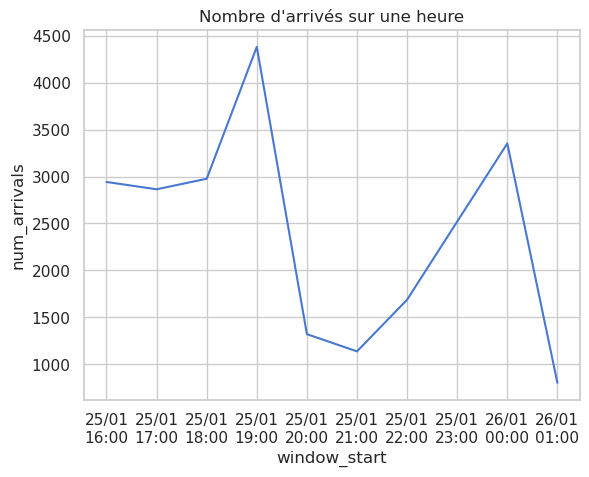

: 

In [ ]:
# Parse Kafka messages
parsed_stream = flights_df.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select(
        col("data.lastSeen").cast(TimestampType()).alias("ArrivalTime"),
        col("data.estArrivalAirport").alias("Airport")
    )

# Compute number of arrivals over a 60-minute window
rolling_numbers = parsed_stream \
    .groupBy(window(col("ArrivalTime"), "60 minutes")) \
    .count() \
    .select(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("count").alias("num_arrivals")
    ).orderBy("window_start")

# Collect the result as a Pandas DataFrame
pandas_df = rolling_numbers.toPandas()
pandas_df

g = sns.lineplot(data=pandas_df, x="window_start", y="num_arrivals")
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m\n%H:%M'))
g.set_title("Nombre d'arrivés sur une heure")

### Mode batch sans fenêtre

In [ ]:
flight_counts = flights_json \
    .groupBy("estDepartureAirport", "estArrivalAirport") \
    .count() \
    .withColumnRenamed("count", "flight_count")

# Créer un DataFrame pour les arêtes (vols)
nbVols = flight_counts.select(
    col("estDepartureAirport").alias("src"),
    col("estArrivalAirport").alias("dst"),
    col("flight_count")
)
# on se limite au 15 aéroports les plus fréquentés
top_n = 15

# Identifier les aéroports les plus fréquentés (combinaison de départs et arrivées)
top_airports = (
    flight_counts.select("estDepartureAirport").union(flight_counts.select("estArrivalAirport"))
    .groupBy("estDepartureAirport").count()
    .orderBy(desc("count"))
    .limit(top_n)
    .select("estDepartureAirport").collect()
)
top_airport_codes = [row['estDepartureAirport'] for row in top_airports]

# Filtrer le dataframe pour n'inclure que les vols entre ces aéroports principaux
filtered_counts = flight_counts.filter(
    (col("estDepartureAirport").isin(top_airport_codes)) & 
    (col("estArrivalAirport").isin(top_airport_codes))
)

filtered_counts

25/02/18 15:51:51 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 15:51:51 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


DataFrame[estDepartureAirport: string, estArrivalAirport: string, flight_count: bigint]

: 

25/02/18 16:02:07 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 16:02:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+----+------------+
| src| dst|flight_count|
+----+----+------------+
|KFXE|KFXE|          77|
|KHWO|KHWO|          50|
|KFFZ|KFFZ|          50|
|KTMB|KTMB|          33|
|KEWR|KEWR|          31|
|KCOI|KCOI|          30|
|KPDK|KPDK|          30|
|KE25|KDVT|          29|
|KDVT|KDVT|          29|
|KAUO|KAUO|          28|
|KEVB|KEVB|          26|
|KSSF|KSSF|          26|
|KMLB|KMLB|          26|
|CYVR|CYYJ|          22|
|KVNY|KVNY|          22|
+----+----+------------+



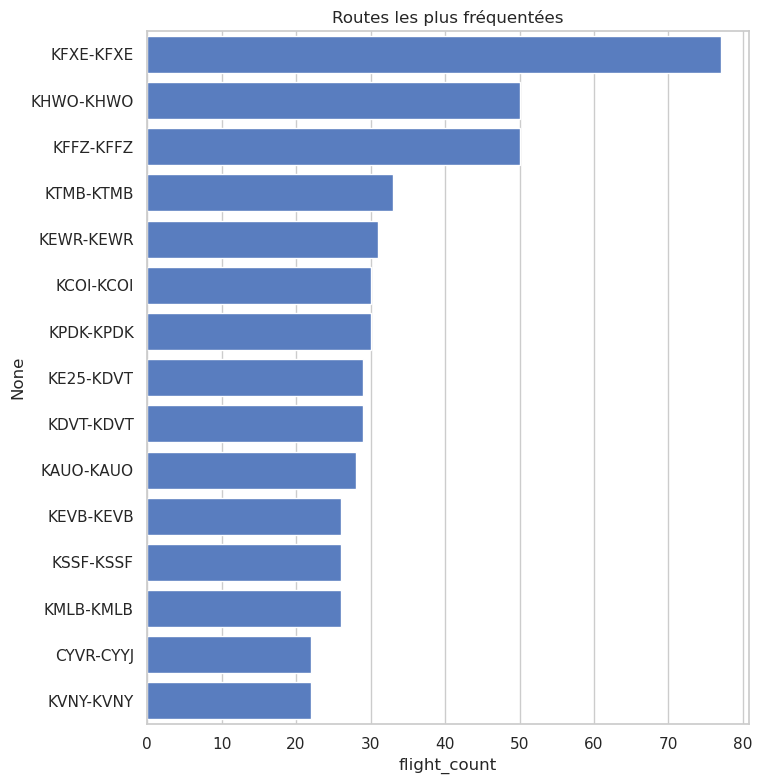

: 

In [ ]:
# Filtrer les données qui valent NULL
filtered_nbVols = nbVols.filter(
    (col("src").isNotNull()) & 
    (col("dst").isNotNull())
)

# Trouver les routes les plus empruntées
top_routes = filtered_nbVols.orderBy(desc("flight_count")).limit(top_n)
top_routes.show()

# Convertir en pandas pour visualisation avec Seaborn
top_routes_pd = top_routes.toPandas()

# Créer des visualisations
plt.figure(figsize=(14, 8))

# Graphique des routes les plus fréquentées
plt.subplot(1, 2, 2)
sns.barplot(x="flight_count", y=top_routes_pd.apply(lambda x: f"{x['src']}-{x['dst']}", axis=1), 
            data=top_routes_pd, orient="h")
plt.title("Routes les plus fréquentées")
plt.tight_layout()

plt.savefig("aviation_network_analysis.png")
plt.show()
plt.close()

In [ ]:
# Convertir en pandas pour le pivot
matrix_data = filtered_counts.toPandas()

# Créer la matrice pivot
flight_matrix = matrix_data.pivot(index='estDepartureAirport', columns='estArrivalAirport', values='flight_count')
flight_matrix = flight_matrix.fillna(0)  # Remplacer les NaN par 0

# Créer le heatmap
plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    flight_matrix,
    annot=True,           # Afficher les valeurs
    fmt='g',              # Format des nombres (entiers)
    cmap='YlGnBu',        # Palette de couleurs (jaune-vert-bleu)
    linewidths=0.5,       # Lignes entre les cellules
    cbar_kws={'label': 'Nombre de vols'}
)

# Ajuster les étiquettes et le titre
plt.title('Nombre de vols entre les principaux aéroports', fontsize=16)
plt.xlabel('Destinations', fontsize=12)
plt.ylabel('Origines', fontsize=12)

# Rotation des étiquettes pour la lisibilité
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder et afficher
plt.savefig("/tmp/flight_heatmap_origin_destination.png", dpi=300)
# plt.show()
plt.close()

# Obtenir quelques statistiques sur cette matrice
nonzero_routes = (flight_matrix > 0).sum().sum()
total_possible_routes = len(top_airport_codes) * len(top_airport_codes)
connectivity_ratio = nonzero_routes / total_possible_routes

print(f"Parmi les {top_n} principaux aéroports:")
print(f"Nombre total de routes possibles: {total_possible_routes}")
print(f"Nombre de routes effectivement desservies: {nonzero_routes}")
print(f"Ratio de connectivité: {connectivity_ratio:.2%}")
print(f"Nombre moyen de vols par route active: {flight_matrix.sum().sum() / nonzero_routes:.1f}")

25/02/18 15:52:01 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Parmi les 15 principaux aéroports:
Nombre total de routes possibles: 225
Nombre de routes effectivement desservies: 24
Ratio de connectivité: 10.67%
Nombre moyen de vols par route active: 11.8


: 

## Requête avec SparkSQL

In [ ]:
# Enregistrer le DataFrame en tant que table temporaire
flights_json.createOrReplaceTempView("flights")

# Top 5 de la correspondance la plus fréquente
query = """
SELECT estDepartureAirport, estArrivalAirport, COUNT(*) as count
FROM flights
WHERE estDepartureAirport IS NOT NULL AND estArrivalAirport IS NOT NULL AND estDepartureAirport != estArrivalAirport
GROUP BY estDepartureAirport, estArrivalAirport
ORDER BY count DESC
LIMIT 5
"""

top_5_couples = sql_context.sql(query)

# Afficher les résultats
top_5_couples.show()

25/02/18 15:52:06 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------------------+-----------------+-----+
|estDepartureAirport|estArrivalAirport|count|
+-------------------+-----------------+-----+
|               KE25|             KDVT|   29|
|               CYVR|             CYYJ|   22|
|               FL31|             KTMB|   17|
|               KE63|             KE25|   17|
|               PANC|             PAEN|   16|
+-------------------+-----------------+-----+



: 

## Requête en mode batch et résultats sous forme de graphiques

In [ ]:
# Afficher un exemple brut
flights_df.selectExpr("CAST(value AS STRING)").show(5, False)

25/02/18 15:52:08 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

: 

In [ ]:
filtered_flights = flights_json.filter(
    (col("estDepartureAirport").isNotNull()) &
    (col("estArrivalAirport").isNotNull())
)

outbound = filtered_flights.groupBy("estDepartureAirport") \
    .agg(count("*").alias("vols_sortants")) \
    .orderBy(desc("vols_sortants"))

inbound = filtered_flights.groupBy("estArrivalAirport") \
    .agg(count("*").alias("vols_entrants")) \
    .orderBy(desc("vols_entrants"))


: 

25/02/18 15:52:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 15:52:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
/tmp/ipykernel_610/71589102.py:9: FutureWarning:                                

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


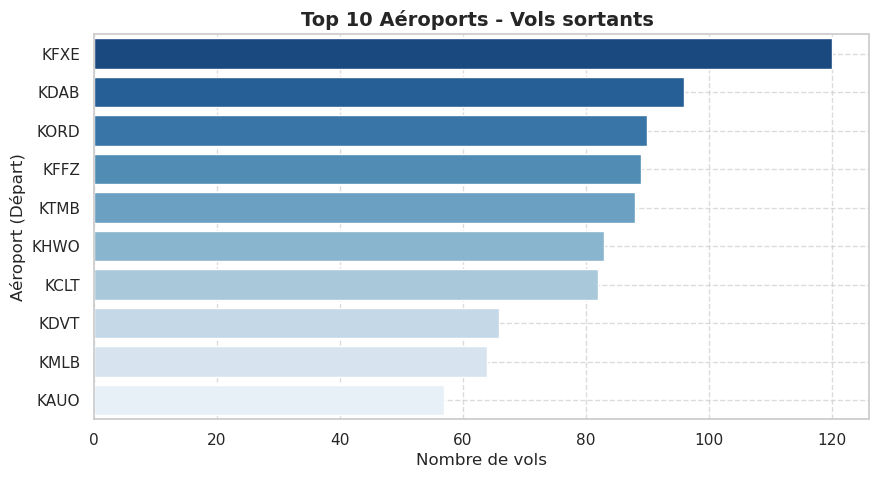

/tmp/ipykernel_610/71589102.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


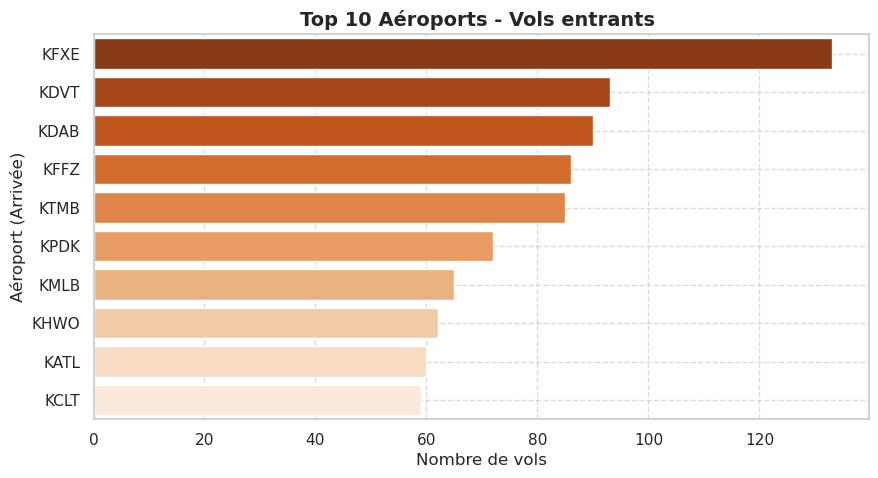

: 

In [ ]:
outbound_pd = outbound.limit(10).toPandas()
inbound_pd = inbound.limit(10).toPandas()

# 🎨 Configurer le style Seaborn
sns.set_theme(style="whitegrid", palette="muted")

# 📈 Vols sortants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_sortants",
    y="estDepartureAirport",
    data=outbound_pd,
    palette="Blues_r"
)
plt.title("Top 10 Aéroports - Vols sortants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Départ)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 📊 Vols entrants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_entrants",
    y="estArrivalAirport",
    data=inbound_pd,
    palette="Oranges_r"
)
plt.title("Top 10 Aéroports - Vols entrants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Arrivée)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Spark streaming

## Definir the shema de données states

In [ ]:
# Define the schema matching the JSON structure of the state data
schema = StructType() \
    .add("icao24", StringType()) \
    .add("callsign", StringType()) \
    .add("origin_country", StringType()) \
    .add("time_position", DoubleType()) \
    .add("last_contact", DoubleType()) \
    .add("longitude", DoubleType()) \
    .add("latitude", DoubleType()) \
    .add("altitude", DoubleType()) \
    .add("on_ground", BooleanType()) \
    .add("velocity", DoubleType()) \
    .add("heading", DoubleType()) \
    .add("vertical_rate", DoubleType()) \
    .add("sensors", StringType()) \
    .add("geo_altitude", DoubleType()) \
    .add("squawk", StringType()) \
    .add("spi", BooleanType()) \
    .add("position_source", StringType())

: 

: 

: 

## Création des Streaming Queries

In [ ]:
# Read from the Kafka topic 'opensky_filtered_flights'
df_filtered_flights = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky_filtered_flights") \
    .option("startingOffsets", "earliest") \
    .load()

# Convert Kafka binary messages to JSON, then extract the fields using the defined schema,
# and add an event timestamp for windowing.
df_filtered_flights = df_filtered_flights.selectExpr("CAST(value AS STRING) as json_value") \
    .select(from_json(col("json_value"), schema).alias("data")) \
    .select("data.*") \
    .withColumn("event_time", current_timestamp())

# Query 1: Aggregate flights by 'origin_country' over a 1-minute window.
df_filtered_windowed = df_filtered_flights.groupBy(
    window(col("event_time"), "1 minute"),
    col("origin_country")
).count()

# Query 2: Bucket flights by altitude range and count them per 1-minute window.
df_bucketed = df_filtered_flights.withColumn(
    "altitude_range",
    when(col("altitude") < 5000, "Low")
    .when((col("altitude") >= 5000) & (col("altitude") < 15000), "Medium")
    .otherwise("High")
)

df_bucket_count = df_bucketed.groupBy(
    window(col("event_time"), "1 minute"),
    col("altitude_range")
).count()

: 

## Affichage des Streaming Queries

In [ ]:
# Write the altitude bucket count query output to the console
query_bucket = df_bucket_count.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

# Write the filtered flights aggregation (by country) to the console
query_filtered = df_filtered_windowed.writeStream \
    .outputMode("update") \
    .format("console") \
    .start()


# Uncomment the following lines if you wish to block execution:
query_bucket.awaitTermination()
query_filtered.awaitTermination()

: 